In [6]:
from transformers import AutoTokenizer
from collections import defaultdict

In [3]:
with open("law.txt", "r", encoding="utf-8") as f:
    corpus = f.read()

with open("wizoz.txt", "r", encoding="utf-8") as f:
    corpus_wizoz = f.read()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
class WordPieceTokenizer:
    def __init__(self, vocab_size=100, unk_token="[UNK]", special_tokens=None):
        self.vocab_size = vocab_size
        self.unk_token=unk_token
        self.special_tokens = special_tokens
        self.vocab = []
    
    def merge_pair(self, a, b, splits, word_freqs):
        for word in word_freqs:
            split = splits[word]
            if len(split) == 1: # can't merge single char
                continue
            i=0
            while i < len(split) - 1:
                if split[i] == a and split[i+1] == b: #correct letters, merg
                    merge = a + b[2:] if b.startswith('##') else a + b
                    split = split[:i] + [merge] + split[i+2:]
                else:
                    i += 1

            splits[word] = split
        return splits

    # Compute scores for pairs of words
    def compute_pair_scores(self, splits, word_freqs):
        # score is computed by pair freq/(letter 1 freq + letter 2 freq)
        letter_freqs = defaultdict(int)
        pair_freqs = defaultdict(int)
        for word, freq in word_freqs.items():
            split = splits[word]
            if len(split) == 1: # if word is one char
                letter_freqs[split[0]] += 1
    
                continue
            for i in range(len(split) - 1): # Minus 1 because the last char can't be paired with anything
                pair = (split[i], split[i+1])
                pair_freqs[pair] += 1 # add one to pair freq
                letter_freqs[split[i]] += 1 # add one to letter freq of current letter
            # add frequency for last letter since we skipped
            letter_freqs[split[-1]] += 1
    
        # compute scores
        scores = {
            pair: freq / (letter_freqs[pair[0]] + letter_freqs[pair[1]]) for pair, freq in pair_freqs.items()
        }
        return scores
    
    def find_best_pair(self, scores):
        best_pair = ""
        max_score = None
        for pair, score in scores.items():
            if max_score is None or score > max_score:
                best_pair = pair
                max_score = score
    
        return best_pair, max_score

    def encode_word(self, word):
        tokens = []
        while len(word) > 0:
            i = len(word)
            while i > 0 and word[:i] not in self.vocab: # keep decrementing until we reach a subword that is in vocab
                i -= 1
            if i == 0: # unknown word
                return [self.unk_token]
            tokens.append(word[:i])
            word = word[i:]
            if len(word) > 0:
                word = f'##{word}' # prefix with ##
        return tokens

    
    def train(self, text):
        """
        Returns words_freqs, new vocab list, and splits
        """
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text) # Split into individual words
        new_words = [word for word, offset in words_with_offsets]
        word_freqs = defaultdict(int)
        for word in new_words:
            word_freqs[word] += 1
        alphabet = []
    
        for word in word_freqs.keys():
            # add first letter without ##
            if word[0] not in alphabet:
                alphabet.append(word[0])
            for letter in word[1:]:
                if f'##{letter}' not in alphabet:
                    alphabet.append(f'##{letter}')
        # add special tokens
        self.vocab = [self.unk_token] + self.special_tokens + alphabet.copy()
        # split each word into characters, each character not starting word is preced by ##
        splits = {
            word: [c if i == 0 else f'##{c}' for i, c, in enumerate(word)] for word in word_freqs.keys()
        }
        while len(self.vocab) < self.vocab_size:
            scores = self.compute_pair_scores(splits, word_freqs)
            best_pair, max_score = self.find_best_pair(scores)
            splits = self.merge_pair(best_pair[0], best_pair[1], splits, word_freqs)
            new_token = (
                    best_pair[0] + best_pair[1][2:]
                    if best_pair[1].startswith("##")
                    else best_pair[0] + best_pair[1]
                )
            self.vocab.append(new_token)

    def tokenize(self, text):
        pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        encoded_words = [self.encode_word(word) for word in pre_tokenized_text]
        return sum(encoded_words, [])
        

In [14]:
import matplotlib.pyplot as plt

# create tokenizer
tokenizer_literary = WordPieceTokenizer(vocab_size=5000, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer_legal = WordPieceTokenizer(vocab_size=5000, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]"])

# call tokenizer.train
tokenizer_legal.train(corpus)
tokenizer_literary.train(corpus_wizoz)

tokens_legal = tokenizer_legal.tokenize(corpus)
tokens_literary = tokenizer_literary.tokenize(corpus_wizoz)


In [15]:
# unique sets
unique_legal = set(tokens_legal)
unique_literary = set(tokens_literary)

# intersection
common_tokens = unique_legal.intersection(unique_literary)

# Exclusive tokens
exclusive_legal = unique_legal.difference(unique_literary)
exclusive_literary = unique_literary.difference(unique_legal)

print("Number of tokens (legal doc):", len(tokens_legal))
print("Number of tokens (literary doc):", len(tokens_literary))

print("Unique tokens (legal doc):", len(unique_legal))
print("Unique tokens (literary doc):", len(unique_literary))
print("Common tokens:", len(common_tokens))
print("Exclusive to legal doc:", len(exclusive_legal))
print("Exclusive to literary doc:", len(exclusive_literary))

Number of tokens (legal doc): 31332
Number of tokens (literary doc): 51776
Unique tokens (legal doc): 3172
Unique tokens (literary doc): 3018
Common tokens: 590
Exclusive to legal doc: 2582
Exclusive to literary doc: 2428


In [16]:
# Write legal tokens to "tokens_legal.txt"
with open("tokens_legal.txt", "w", encoding="utf-8") as f:
    f.write(" ".join(tokens_legal))

# Write literary tokens to "tokens_literary.txt"
with open("tokens_literary.txt", "w", encoding="utf-8") as f:
    f.write(" ".join(tokens_literary))

In [18]:
vocab_sizes = [100, 200, 500, 1000, 2500, 3000, 3500, 4000, 4500, 5000]
token_counts_legal = []
token_counts_literary = []

for vs in vocab_sizes:
    # Create tokenizer
    tokenizer_literary2 = WordPieceTokenizer(vocab_size=vs, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]"])
    tokenizer_legal2 = WordPieceTokenizer(vocab_size=vs, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]"])

    tokenizer_legal2.train(corpus)
    tokenizer_literary2.train(corpus_wizoz)

    tkns_legal = tokenizer_legal2.tokenize(corpus)
    tkns_literary = tokenizer_literary2.tokenize(corpus_wizoz)
    
    token_counts_legal.append(len(tkns_legal))
    token_counts_literary.append(len(tkns_literary))

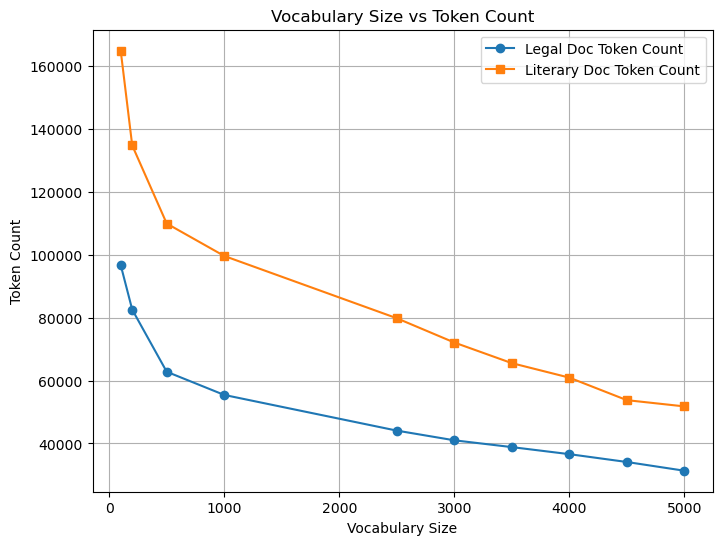

In [20]:
plt.figure(figsize=(8,6))
plt.plot(vocab_sizes, token_counts_legal, marker='o', label='Legal Doc Token Count')
plt.plot(vocab_sizes, token_counts_literary, marker='s', label='Literary Doc Token Count')
plt.title('Vocabulary Size vs Token Count')
plt.xlabel('Vocabulary Size')
plt.ylabel('Token Count')
plt.legend()
plt.grid(True)

plt.savefig("plot.png", dpi=300, bbox_inches='tight')

plt.show()